# Aufgabe 3: Gaußfilter
Anstatt wie in der vorigen Aufgabe an einer ausgewählten Frequenz hart abzuschneiden, kann mittels eines Faktors
\begin{align}
 h(u,v) = \mathrm{e}^{-\frac{D^2(u,v)}{2\sigma^2}},\qquad h \in [0;1]
\end{align}
auch ein weicher Übergang erzeugt werden.

Verwenden Sie eine Gauß-Glocke für die Hoch- und Tiefpassfilterung und berechnen Sie den Faktor $h$ in Abhängigkeit von der Entfernung $D(u,v)$ zum Ursprung!
Führen Sie die Transformationen ansonsten wie in Teilaufgabe 2 durch! Die Varianz $\sigma$ der Gauß-Glocke ist mit dem dort gegebenen Radius gleichzusetzen.
Was ändert sich in den Ausgabebildern im Vergleich zu Teilaufgabe 2?

## 0. Pfade, Pakete etc.

In [25]:
import glob
import urllib.request

%matplotlib inline
import matplotlib.pyplot as plt

import PIL.Image
import numpy as np

In [26]:
image_filter = '../Bilder/*.jpg'

## 1. Definition des Filters

Übernehmen Sie hier zu Vergleichszwecken Ihre Definition des idealen Hoch- und Tiefpass-Filters aus der vorigen Aufgabe:

In [27]:
D0 = 30
lowpass_filter = lambda D: (D <= D0).astype(np.float32)
highpass_filter = lambda D: (D > D0).astype(np.float32)

Definieren Sie den Gauß-Filter als Funktion des Radius $D$ und der Konstante $\sigma$:

In [28]:
sigma = 20
gauss_lowpass = lambda D: np.exp(-(D**2) / (2 * sigma**2))
gauss_highpass = lambda D: 1 - np.exp(-(D**2) / (2 * sigma**2))

## 2. Laden und Normalisieren des Bildes

In [29]:
image_path = np.random.choice(glob.glob(image_filter))
image = np.asarray(PIL.Image.open(image_path).convert('L'))
image = image.astype(np.float32)
image -= image.min()
image /= image.max()
image_transformed = np.fft.fftshift(np.fft.fft2(image))

In [30]:

def ex3_filter_spectrum(spectrum, radial_filter):
    # Dimensionen des Spektrums
    height, width = spectrum.shape

    # Mittelpunkt des Spektrums
    center_y, center_x = height // 2, width // 2

    # Koordinatengitter erstellen
    y = np.arange(height)
    x = np.arange(width)
    yy, xx = np.meshgrid(y, x, indexing='ij')

    # Abstände vom Mittelpunkt berechnen (Radius D)
    D = np.sqrt((yy - center_y)**2 + (xx - center_x)**2)

    # Filter anwenden (radiusabhängige Gewichtung)
    filter_mask = radial_filter(D)

    # Spektrum mit Filter multiplizieren
    filtered_spectrum = spectrum * filter_mask

    return filtered_spectrum

Das transformierte Bild (Spektrum) wird nun gefiltert:

In [31]:
image_transformed_lowpass = ex3_filter_spectrum(image_transformed, lowpass_filter)
image_transformed_highpass = ex3_filter_spectrum(image_transformed, highpass_filter)
image_transformed_gauss_lowpass = ex3_filter_spectrum(image_transformed, gauss_lowpass)
image_transformed_gauss_highpass = ex3_filter_spectrum(image_transformed, gauss_highpass)
# Inverse Fouriertransformation für alle Filter
image_filtered_lowpass = np.abs(np.fft.ifft2(np.fft.ifftshift(image_transformed_lowpass)))
image_filtered_highpass = np.abs(np.fft.ifft2(np.fft.ifftshift(image_transformed_highpass)))
image_filtered_gauss_lowpass = np.abs(np.fft.ifft2(np.fft.ifftshift(image_transformed_gauss_lowpass)))
image_filtered_gauss_highpass = np.abs(np.fft.ifft2(np.fft.ifftshift(image_transformed_gauss_highpass)))

# Normalisierung auf [0, 1]
for img in [image_filtered_lowpass, image_filtered_highpass, image_filtered_gauss_lowpass, image_filtered_gauss_highpass]:
    img -= img.min()
    img /= img.max()


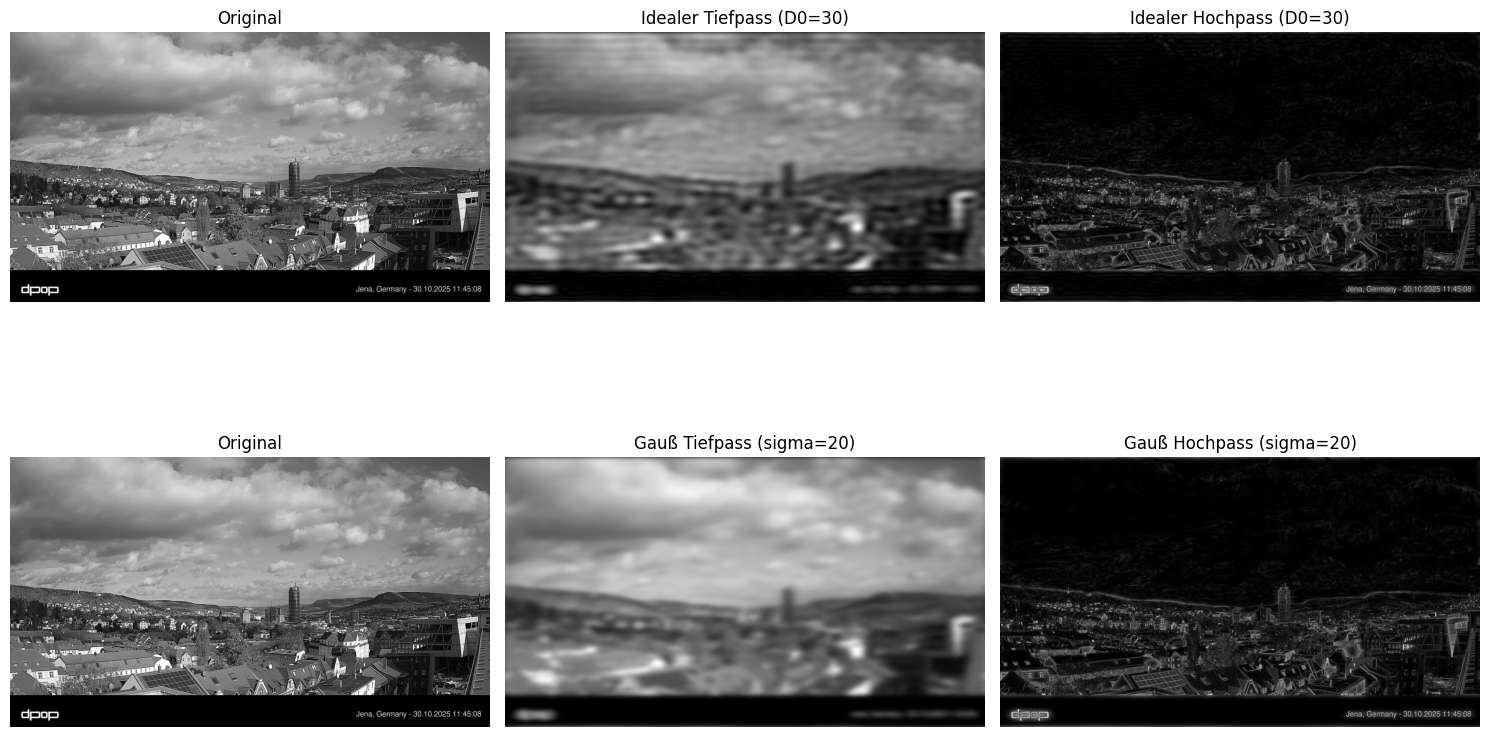

In [32]:
# Visualisierung aller vier Filter
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Erste Zeile: Original und ideale Filter
axes[0, 0].imshow(image, cmap='gray')
axes[0, 0].set_title('Original')
axes[0, 0].axis('off')

axes[0, 1].imshow(image_filtered_lowpass, cmap='gray')
axes[0, 1].set_title(f'Idealer Tiefpass (D0={D0})')
axes[0, 1].axis('off')

axes[0, 2].imshow(image_filtered_highpass, cmap='gray')
axes[0, 2].set_title(f'Idealer Hochpass (D0={D0})')
axes[0, 2].axis('off')

# Zweite Zeile: Gauß-Filter
axes[1, 0].imshow(image, cmap='gray')
axes[1, 0].set_title('Original')
axes[1, 0].axis('off')

axes[1, 1].imshow(image_filtered_gauss_lowpass, cmap='gray')
axes[1, 1].set_title(f'Gauß Tiefpass (sigma={sigma})')
axes[1, 1].axis('off')

axes[1, 2].imshow(image_filtered_gauss_highpass, cmap='gray')
axes[1, 2].set_title(f'Gauß Hochpass (sigma={sigma})')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()


VERGLEICH: Ideale Filter vs. Gauß-Filter


"IDEALE" FILTER (Aufgabe 2):
----------------------------------------------------------------------
+ Tiefpass: Scharfe Grenze bei D = D0
  - Alle Frequenzen mit D <= D0: Faktor = 1
  - Alle Frequenzen mit D > D0: Faktor = 0
  - Ergebnis: Glatteres Bild, aber mit Ripple-Artefakten (wegen der entstehenden sinc-Funktionen)

+ Hochpass: Scharfe Grenze bei D = D0
  - Alle Frequenzen mit D <= D0: Faktor = 0
  - Alle Frequenzen mit D > D0: Faktor = 1
  - Ergebnis: Betonte Kanten, wieder mit Ripple-Artefakten


GAUß-FILTER (Aufgabe 3):
----------------------------------------------------------------------
+ Tiefpass: Sanfter Übergang mit Gauß-Glocke
  - h(D) = exp(-D² / (2sigma²))
  - D = 0: h = 1 (vollständig erhalten)
  - D = sigma: h ≈ 0.6 (60% erhalten)
  - D >> sigma: h ≈ 0 (praktisch unterdrückt)
  - Ergebnis: Glatteres Bild, WENIGER RINGING-ARTEFAKTE

+ Hochpass: Sanfter Übergang mit invertierter Gauß-Glocke
  - h(D) = 1 - exp(-D² / (2 sigma²))
  - D = 0: h = 0 (niedrige Frequenzen unterdrückt)
  - D = sigma: h rund 0.4 (40% Übergang)
  - D >> sigma: h rund 1 (hohe Frequenzen erhalten)
  - Ergebnis: Betonte Kanten, WENIGER RINGING-ARTEFAKTE


HAUPTUNTERSCHIEDE:
----------------------------------------------------------------------
1. RINGING-ARTEFAKTE:
   - Ideale Filter: Scharfe Übergänge → Ringing-Artefakte
   - Gauß-Filter: Sanfte Übergänge → Weniger/keine Ringing-Artefakte

2. FREQUENZÜBERGANG:
   - Ideale Filter: Hart an/aus bei D = D0
   - Gauß-Filter: Gradueller Übergang über Range von sigma

3. BILDQUALITÄT:
   - Ideale Filter: Stärker manipuliert, aber detaillierter
   - Gauß-Filter: Sanfter, natürlichere Übergänge

4. ANWENDUNG:
   - Ideale Filter: Theoretisch interessant, praktisch problematisch
   - Gauß-Filter: Praktisch bevorzugt wegen besserer Bildqualität
